In [33]:
import os 
import pandas as pd 
import numpy as np 
import tarfile
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns 

In [131]:
plot_dir = '/cluster/work/grlab/projects/projects2020_OHSU/plots'
plot_dir = os.path.join(plot_dir, 'tryptic_plots')
#os.mkdir(plot_dir)
base_plot = 'v2_v2.5f0752a_conf2_BRCA'
global plot_dir
global base_plot
pipeline = 'G'

In [35]:
# paths 
path_tryptic_pep= '/cluster/work/grlab/projects/projects2020_OHSU/share_OHUS_PNLL/tryptic_peptide_fastas'

path_filtered_pep = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/v2_v2.5f0752a_conf2_annotFrame_cap0_runs_pya0.17.1/TCGA_Breast_1102'

commit_interest = 'commit_d4aee54_GTEXcore' # hardcoded cohort 

path_eth = os.path.join(path_tryptic_pep, 'G_tryptic_peptides')

file_name = 'peptide-extracted-filter.fasta'

In [36]:
samples = ['TCGA-BH-A18V-01A-11R-A12D-07','TCGA-C8-A12P-01A-11R-A115-07',
           'TCGA-A2-A0D2-01A-21R-A034-07','TCGA-A2-A0SX-01A-12R-A084-07',
           'TCGA-AO-A0JM-01A-21R-A056-07']

In [37]:
sample = samples[0]

In [38]:
samples

['TCGA-BH-A18V-01A-11R-A12D-07',
 'TCGA-C8-A12P-01A-11R-A115-07',
 'TCGA-A2-A0D2-01A-21R-A034-07',
 'TCGA-A2-A0SX-01A-12R-A084-07',
 'TCGA-AO-A0JM-01A-21R-A056-07']

In [39]:
print(sample)

TCGA-BH-A18V-01A-11R-A12D-07


In [40]:
# Tryptic digestion products from Andy Lin 
data_tryptic = []
counter = 0 
with open(os.path.join(path_eth, 'G_' + sample, file_name ), 'r') as f: 
    for line in f.readlines():
        if 'pepID' in line:
            counter +=1
            data_tryptic.append ([line.split('\n')[0]])
        else:
            data_tryptic[-1].extend([counter, line.split('\n')[0]])


data_tryptic = pd.DataFrame(data_tryptic)
data_tryptic.columns = ['id', 'counter', 'tryptic_seq']

In [41]:
assert(data_tryptic['id'].unique().shape[0] == data_tryptic.shape[0])

In [42]:
data_tryptic.shape

(26122, 3)

In [43]:
data_tryptic['id'].unique().shape[0]

26122

In [44]:
data_tryptic['tryptic_seq'].unique().shape

(2883,)

In [45]:
# Filtered peptides to query (longlist for sample)
data_meta = []
with open(os.path.join(path_filtered_pep, f'filter_{sample}.all', commit_interest, f'G_{sample}_query_peptides.fa'), 'r') as f :
    for line in f.readlines():
        if 'pepID' in line:
            data_meta.append(line.split('\n')[0].split(';'))
        else:
            data_meta[-1].extend([line.split('\n')[0]])

data_meta = pd.DataFrame(data_meta)
data_meta.columns = ['id', 'jx_pos', 'between_codons', 'include5', 'include3', 'gene', 'coord', 'seq']

In [46]:
data_meta.head(3)

,id,jx_pos,between_codons,include5,include3,gene,coord,seq
0,>pepID-1,jx_pos-12,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000119333.11,jx_coord-128640690_128636438,WLRGELDRAAADGWTMGTGARLSPSCVPGTWTGETCVPSSRRPWWR...
1,>pepID-2,jx_pos-27,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000086758.16,jx_coord-53550665_53549505,ATVGSSILALLCREVAPSRWGVAAAITGLLAVM
2,>pepID-3,jx_pos-6,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000120149.9,jx_coord-174725038_174729158,PIFAAAKTYEPYHLHPEETQDQSEAAHALYHIPAPRPGAQVPSETV...


In [47]:
# merge tryptic, peptide metadata
df = data_meta.merge(data_tryptic, on = 'id', how = 'outer')

df['len_pep'] = [len(x) for x in df['seq']]

df['has_tryptic'] = 1
df.loc[df['tryptic_seq'].isna(), 'has_tryptic'] = 0 

In [48]:
df.head()

,id,jx_pos,between_codons,include5,include3,gene,coord,seq,counter,tryptic_seq,len_pep,has_tryptic
0,>pepID-1,jx_pos-12,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000119333.11,jx_coord-128640690_128636438,WLRGELDRAAADGWTMGTGARLSPSCVPGTWTGETCVPSSRRPWWR...,1.0,AAADGWTMGTGAR,116,1
1,>pepID-2,jx_pos-27,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000086758.16,jx_coord-53550665_53549505,ATVGSSILALLCREVAPSRWGVAAAITGLLAVM,2.0,WGVAAAITGLLAVM,33,1
2,>pepID-3,jx_pos-6,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000120149.9,jx_coord-174725038_174729158,PIFAAAKTYEPYHLHPEETQDQSEAAHALYHIPAPRPGAQVPSETV...,NaN,NaN,123,0
3,>pepID-4,jx_pos-6,between_codons-1,includes_5'-0,includes_3'-1,gene-ENSG00000120149.9,jx_coord-174725038_174729158,PIFAAAKTYEPYHLHPEETQDQSEAAHALYHIPAPRPGAQVPSETV...,NaN,NaN,123,0
4,>pepID-5,jx_pos-90,between_codons-0,includes_5'-1,includes_3'-1,gene-ENSG00000120149.9,jx_coord-174724853_174725017,MASPSKGNDLFSPDEEGPAVVAGPGPGPGGAEGAAEERRVKVSSLP...,3.0,TYEPYHLHPEETQDQSEAAHALYHIPAPR,188,1


Shapes 

In [49]:
df.shape

(42743, 12)

In [50]:
df['seq'].unique().shape

(5193,)

In [51]:
df['coord'].unique().shape

(4213,)

In [52]:
df.loc[ df['has_tryptic'] == 1 ].shape

(26122, 12)

In [53]:
df.loc[df['has_tryptic'] == 1 , 'tryptic_seq'].unique().shape

(2883,)

In [54]:
# counting the length 
grp_len = df[['coord', 'len_pep']].groupby(['coord']).min().reset_index()

grp_len = df[['coord', 'len_pep']].groupby(['coord']).min().reset_index()

In [55]:
grp_len.head()

,coord,len_pep
0,jx_coord-100030375_100033304,323
1,jx_coord-1000469_997804,201
2,jx_coord-100097613_100097384,26
3,jx_coord-100097617_100097642,55
4,jx_coord-100097658_100102303,39


In [56]:
# Counting tryptic
grp_trypt = df[['coord', 'tryptic_seq']].groupby(['coord', 'tryptic_seq']).count().reset_index()

grp_trypt = grp_trypt.groupby(['coord']).count().reset_index()

In [57]:
# Counting the number of peptides right 
grp_peptides = df[['coord', 'seq']].groupby(['coord', 'seq']).count().reset_index()
grp_peptides = grp_peptides.groupby(['coord']).count().reset_index()

In [58]:
# Merging 
df_plot = grp_trypt.merge(grp_peptides, on = 'coord', how = 'outer')

df_plot['tryptic_seq'] = df_plot['tryptic_seq'].fillna(0)
df_plot = df_plot.merge(grp_len, on = 'coord', how = 'outer')

df_plot['has_tryptic'] = 0
df_plot['has_tryptic'].loc[df_plot['tryptic_seq'] > 0 ] = 1 

/cluster/home/prelotla/software/anaconda3/envs/myimmuno3_light/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [59]:
df_plot.head()

,coord,tryptic_seq,seq,len_pep,has_tryptic
0,jx_coord-100030375_100033304,1.0,1,323,1
1,jx_coord-1000469_997804,1.0,1,201,1
2,jx_coord-100097617_100097642,1.0,1,55,1
3,jx_coord-100097693_100097628,1.0,1,43,1
4,jx_coord-100098140_100097948,1.0,1,46,1


In [132]:
save = True

save to /cluster/work/grlab/projects/projects2020_OHSU/plots/tryptic_plots/v2_v2.5f0752a_conf2_BRCA_TCGA-BH-A18V-01A-11R-A12D-07_G_TrypticPlotLen.pdf


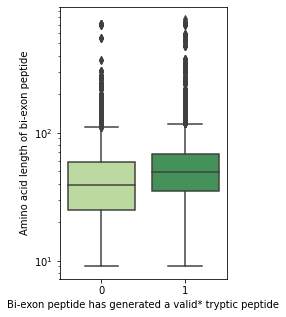

In [133]:
plt.figure(figsize = (3, 5 ))
cmap = plt.cm.coolwarm

sns.boxplot(data = df, y = 'len_pep', x = 'has_tryptic', palette = 'YlGn') # also version in log 
plt.yscale('log')
plt.ylabel('Amino acid length of bi-exon peptide')
plt.xlabel('Bi-exon peptide has generated a valid* tryptic peptide')
if save:
    save_path = os.path.join(plot_dir, 
                            '{}_{}_{}_TrypticPlotLen.pdf'.format(base_plot, 
                             sample, pipeline ))  
    print("save to {}".format(save_path))
    plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [ ]:
print([10**1, 10**1.1, 10**1.2, 10** 1.3, 10** 1.4, 10**1.5, 10**1.6, 10**1.7, 10**1.8, 10**1.9])

save to /cluster/work/grlab/projects/projects2020_OHSU/plots/tryptic_plots/v2_v2.5f0752a_conf2_BRCA_TCGA-BH-A18V-01A-11R-A12D-07_G_TrypticPlotHist.pdf


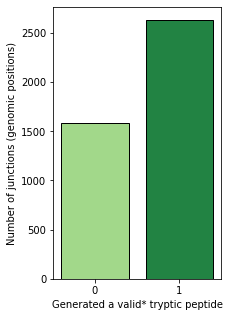

In [135]:
plt.figure(figsize = (3, 5 ))
cmap = plt.cm.YlGn
colors = [cmap(0.4), cmap(0.75)]
ax = plt.bar(*np.unique(df_plot['has_tryptic'], return_counts=True), color = colors, 
       edgecolor = 'k', linewidth=1)
plt.xticks([0,1])
plt.ylabel('Number of junctions (genomic positions)')
plt.xlabel('Generated a valid* tryptic peptide')
if save:
    save_path = os.path.join(plot_dir, 
                            '{}_{}_{}_TrypticPlotHist.pdf'.format(base_plot, 
                             sample, pipeline ))  
    print("save to {}".format(save_path))
    plt.savefig(save_path, bbox_inches='tight')
plt.show()

# Checks from Cancer Cell Paper 

In [ ]:
asn_exp = pd.read_csv('/cluster/work/grlab/projects/TCGA/PanCanAtlas/peptides_neoantigen/analysis_pancan/ccell_rerun_2018/output/expression_distribution/asns/TCGA-BH-A18V.asns_kmers_annotated.gtex.tsv', sep = '\t')

In [ ]:
asn_exp.loc[(asn_exp['PEPTIDE_TYPE'] == 'reference') &\
         (asn_exp['JUNC_COUNT'] > 0 ) &\
       (asn_exp['IN_CPTAC'] == 1), :]

In [ ]:
asn_final = pd.read_csv('/cluster/work/grlab/projects/TCGA/PanCanAtlas/peptides_neoantigen/analysis_pancan/ccell_rerun_2018/output/cptac_mhc/filtered/filtered_for_new_junctions/sites/expression_filtered/TCGA-BH-A18V.gtex.unique_novel_junction_binders.2.0.annotated.sites.expressed.txt', '\t')

In [32]:
asn_final.head()

NameError: name 'asn_final' is not defined

In [ ]:
# Prensent one sample in the power point = the A0 -- plot from yesterday also in A 0 